# Módulos

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
from IPython.display import display, HTML
import numpy as np

cores = {
    
    'valor': (0/255, 98/255, 105/255),
    'valorinveste': (71/255, 47/255, 146/255),
    'pipelinevalor': (158/255, 0/255, 93/255),
    'globorural': (52/255, 131/255, 68/255),
    'epocanegocios': (0/255, 0/255, 0/255),
    'revistapegn': (246/255, 84/255, 17/255),
    'umsoplaneta': (97/255, 155/255, 19/255),
    
}

nomes = {
    
    'valor': 'Valor Econômico',
    'valorinveste': 'Valor Investe',
    'pipelinevalor': 'Pipeline (Valor)',
    'globorural': 'Globo Rural',
    'epocanegocios': 'Época Negócios',
    'revistapegn': 'Revista PEGN',
    'umsoplaneta': 'Um Só Planeta'

}

# Formatação de nomes de tópicos
import re
def formatar_nomes_de_tópicos(texto):
    if re.match(r'^T\d+_', texto):
        texto_formatado = re.sub(r'^T\d+_', '', texto)
        texto_formatado = texto_formatado.replace('_', ' ')
        return f'Tópico: {texto_formatado}'
    else:
        return texto.replace('_', ' ')

# IRFs sobrepostas

## Dados

In [11]:
portal = 'valor'


# VAR

dfs = []
for arquivo in os.listdir('resultados do VAR'):
    if arquivo.startswith(portal + ' - '):
        df = pd.read_excel(f'resultados do VAR/{arquivo}', sheet_name = 'IRFs') 
        df[['portal', 'método', 'dirichlet', 'ação']] = arquivo[:-5].replace(' - total', '').split(' - ')
        dfs.append(df)

VAR = pd.concat(dfs, ignore_index=True)
VAR.variável = VAR.variável.apply(formatar_nomes_de_tópicos)


# LPs

dfs = []
for arquivo in os.listdir('resultados das Local Projections'):
    if arquivo.startswith('resultados - ' + portal + ' - '):
        df = pd.read_excel(f'resultados das Local Projections/{arquivo}') 
        df.columns = ['impulso_resposta', 'variável_resposta', 'defasagem', 'variável', 'banda_inferior', 'banda_superior']
        df = df[df.variável_resposta.str.contains('Ação_')]
        df[['portal', 'método', 'dirichlet', 'ação']] = arquivo[:-5].replace('resultados - ', '').replace(' - total', '').split(' - ')
        dfs.append(df)

LPs = pd.concat(dfs, ignore_index=True)
LPs.variável = LPs.variável.apply(formatar_nomes_de_tópicos)


# Agregação
dfs = LPs.copy()
#dfs = pd.concat([VAR, LPs])

## Funções

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_irf_subplots(variáveis, dfs, n, portal='valor',
                      alpha_irf=0.5, alpha_banda=0.5, alpha_fill=0.05,
                      figsize_per_subplot=(6, 4), dpi=200):
    
    total = len(variáveis)
    for start in range(0, total, n):
        vars_atual = variáveis[start:start + n]
        qtde = len(vars_atual)
        largura, altura = figsize_per_subplot
        fig, axes = plt.subplots(1, n,
                                 figsize=(largura * n, altura),
                                 dpi=dpi)
        axes_arr = axes if isinstance(axes, np.ndarray) else np.array([axes])

        for j, variável in enumerate(vars_atual):
            ax = axes_arr[j]
            df_var = dfs[dfs['variável'] == variável].copy()
            nrow = len(df_var)

            for k in range(13, nrow + 1, 13):
                irf = df_var.iloc[max(0, k - 13):k]
                ax.plot(irf['defasagem'], irf['impulso_resposta'],
                        linewidth=1.7, color=cores[portal],
                        alpha=alpha_irf, marker='o', ms=3)
                ax.plot(irf['defasagem'], irf['banda_inferior'],
                        linewidth=0.7, color=cores[portal],
                        alpha=alpha_banda)
                ax.plot(irf['defasagem'], irf['banda_superior'],
                        linewidth=0.7, color=cores[portal],
                        alpha=alpha_banda)
                ax.fill_between(irf['defasagem'],
                                irf['banda_inferior'], irf['banda_superior'],
                                color=cores[portal], alpha=alpha_fill)

            ax.axhline(0, linestyle='--', color='black', linewidth=2, alpha=0.7)
            ax.grid(visible=True, linestyle=':', color='black', alpha=0.3)
            ax.set_xlabel('Nº de defasagens', fontsize=12, labelpad=5)
            ax.set_xticks(df_var['defasagem'].unique())
            ax.set_title(variável, fontsize=15, pad=10)

        # desliga eixos vazios
        if qtde < n:
            for idx in range(qtde, n):
                axes_arr[idx].axis('off')

        plt.tight_layout()
        plt.show()

In [49]:
import os
import matplotlib.pyplot as plt
import numpy as np

def plot_irf_subplots(variáveis, dfs, n, portal='valor',
                      alpha_irf=0.5, alpha_banda=0.5, alpha_fill=0.05,
                      figsize_per_subplot=(6, 4), dpi=200):

    # Cria a pasta, se não existir
    pasta_destino = "imagem das IRFs via LP"
    os.makedirs(pasta_destino, exist_ok=True)
    
    total = len(variáveis)
    for start in range(0, total, n):
        vars_atual = variáveis[start:start + n]
        qtde = len(vars_atual)
        largura, altura = figsize_per_subplot
        fig, axes = plt.subplots(1, n,
                                 figsize=(largura * n, altura),
                                 dpi=dpi)
        axes_arr = axes if isinstance(axes, np.ndarray) else np.array([axes])

        for j, variável in enumerate(vars_atual):
            ax = axes_arr[j]
            df_var = dfs[dfs['variável'] == variável].copy()
            nrow = len(df_var)

            for k in range(13, nrow + 1, 13):
                irf = df_var.iloc[max(0, k - 13):k]
                ax.plot(irf['defasagem'], irf['impulso_resposta'],
                        linewidth=1.7, color=cores[portal],
                        alpha=alpha_irf, marker='o', ms=3)
                ax.plot(irf['defasagem'], irf['banda_inferior'],
                        linewidth=0.7, color=cores[portal],
                        alpha=alpha_banda)
                ax.plot(irf['defasagem'], irf['banda_superior'],
                        linewidth=0.7, color=cores[portal],
                        alpha=alpha_banda)
                ax.fill_between(irf['defasagem'],
                                irf['banda_inferior'], irf['banda_superior'],
                                color=cores[portal], alpha=alpha_fill)

            ax.axhline(0, linestyle='--', color='black', linewidth=2, alpha=0.7)
            ax.grid(visible=True, linestyle=':', color='black', alpha=0.3)
            ax.set_xlabel('Nº de defasagens', fontsize=12, labelpad=5)
            ax.set_xticks(df_var['defasagem'].unique())
            ax.set_title(variável, fontsize=15, pad=10)

        # Desliga eixos vazios
        if qtde < n:
            for idx in range(qtde, n):
                axes_arr[idx].axis('off')

        plt.tight_layout()

        # Cria nome do arquivo
        nome_arquivo = " - ".join([v.replace("Tópico:", "T. de") for v in vars_atual])
        caminho_completo = os.path.join('imagem das IRFs via LP', f"{nome_arquivo}.jpeg")
        plt.savefig(caminho_completo, format='jpeg')
        plt.show()

## Visualização

In [50]:
controles = ['Petróleo bruto', 'Taxa de câmbio', 'Futuro de DI', 'Índice VIX']
tópicos = sorted(dfs.variável[dfs.variável.str.contains('Tópico: ')].unique())

### Controles

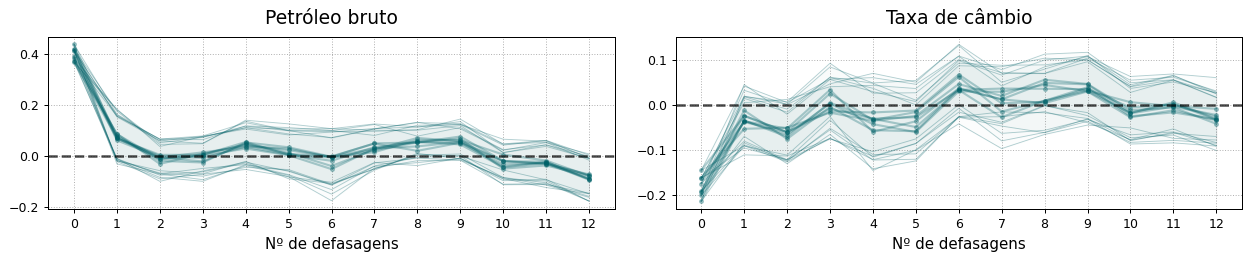

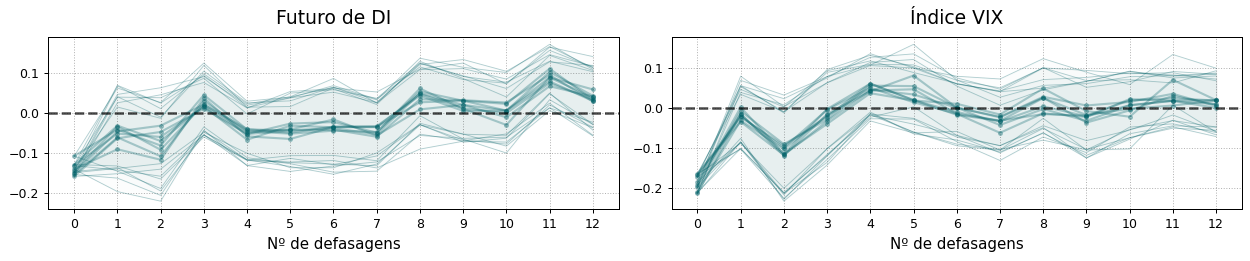

In [51]:
plot_irf_subplots(controles, dfs, 2, 'valor', .3, .3, .01, (7,3), 90)

### Tópicos

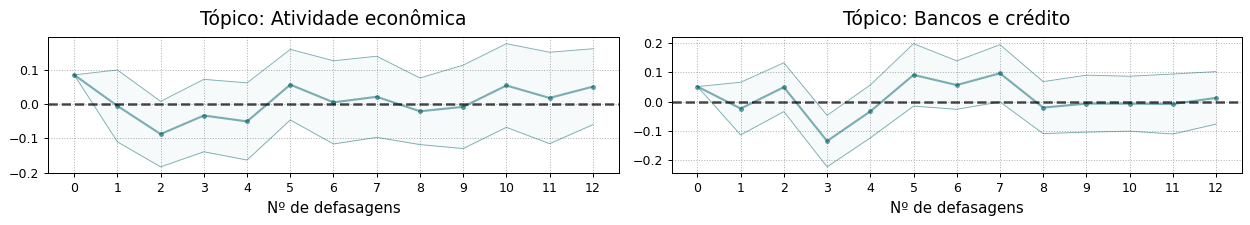

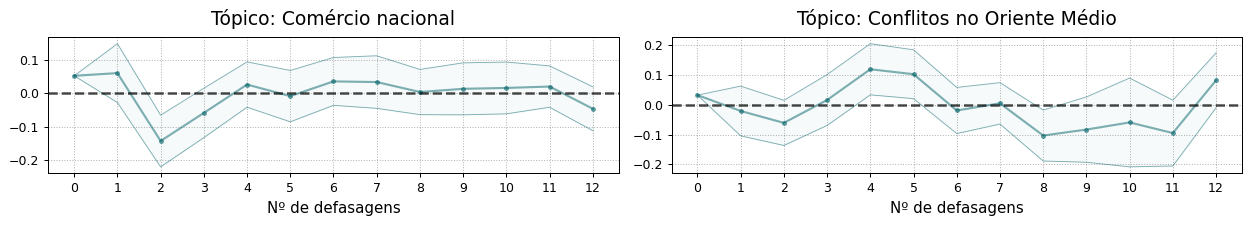

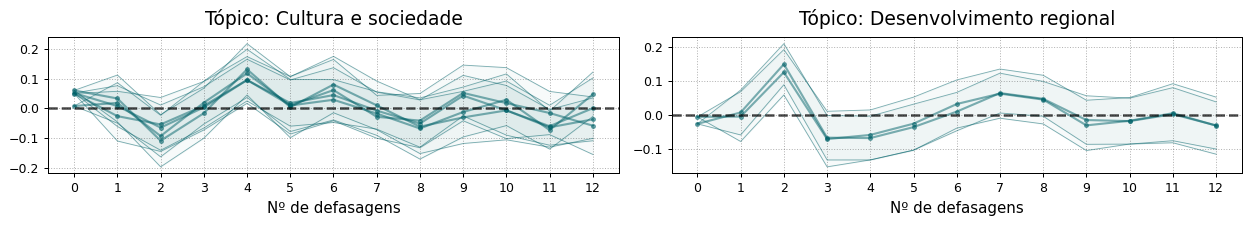

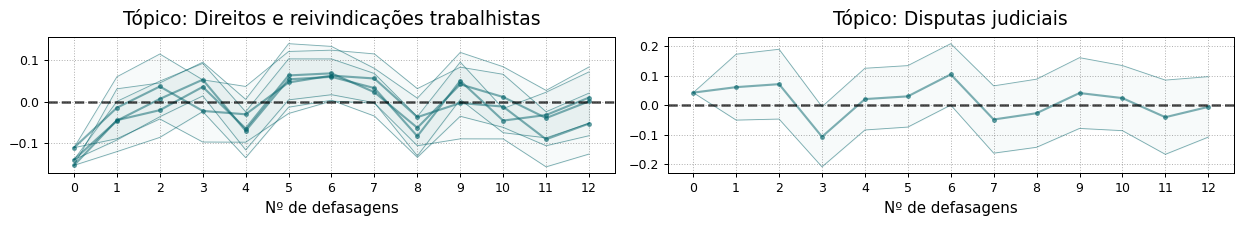

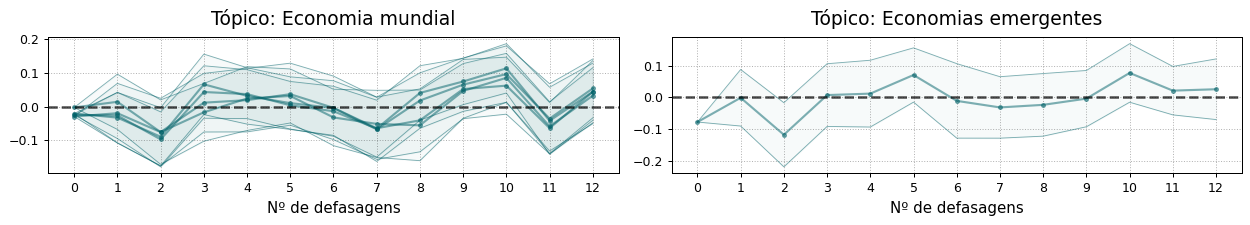

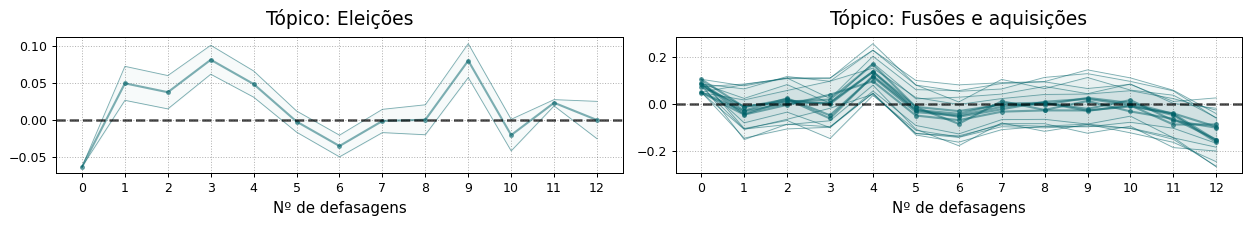

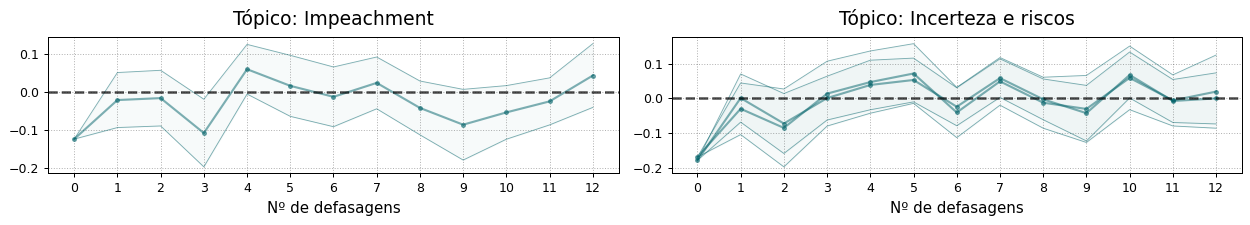

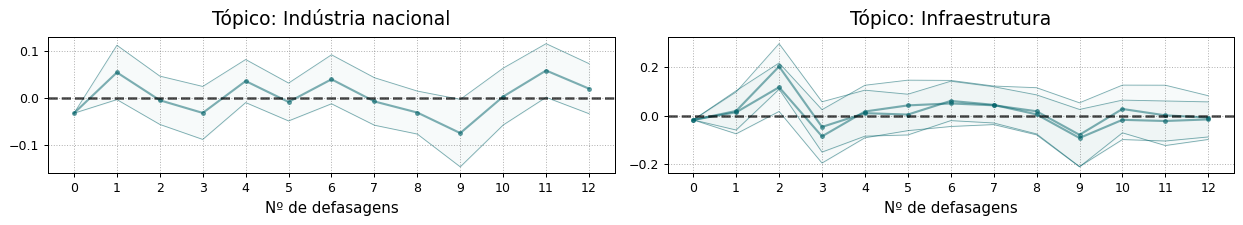

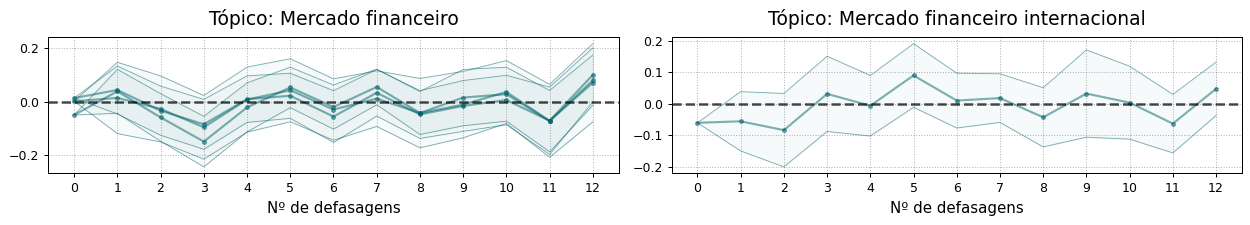

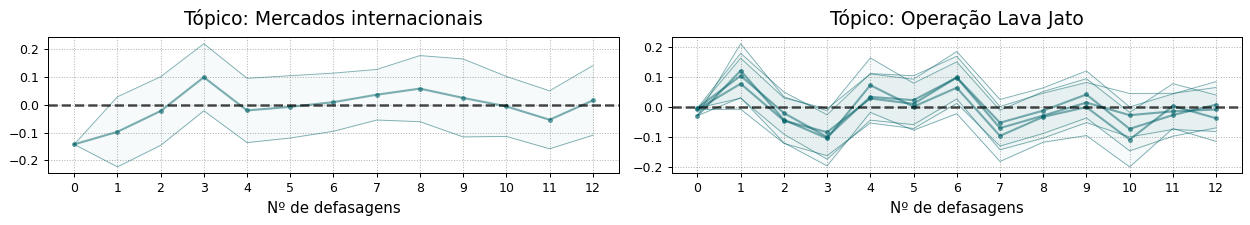

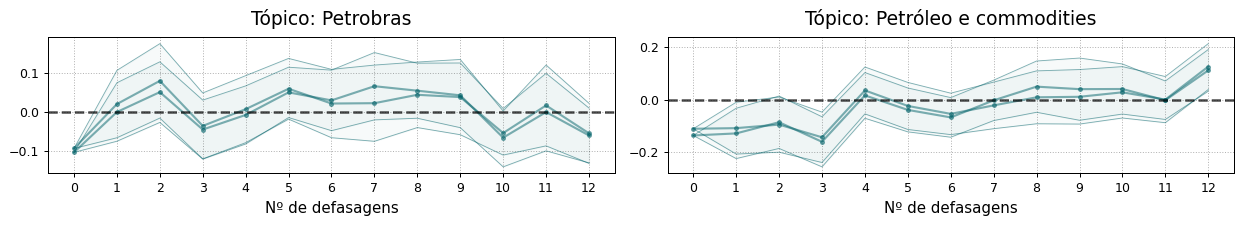

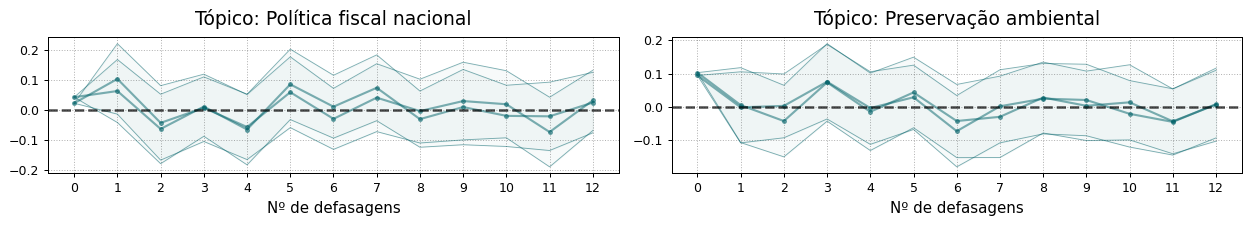

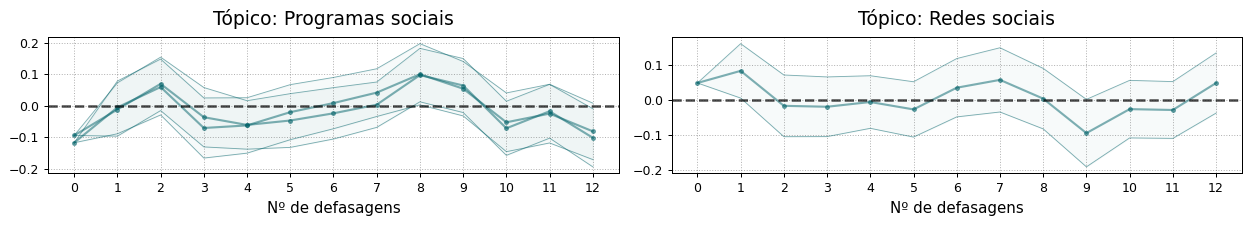

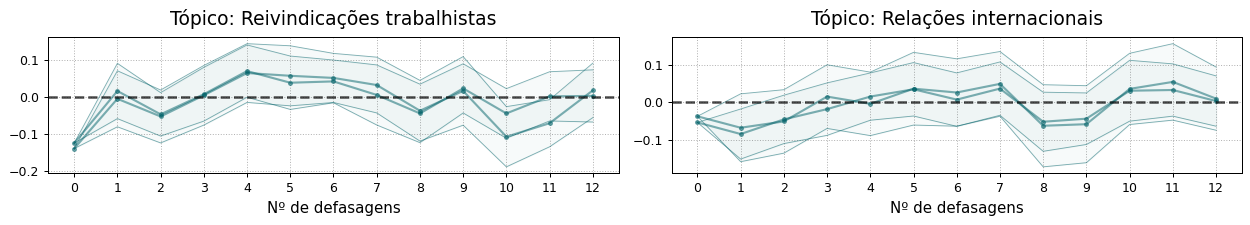

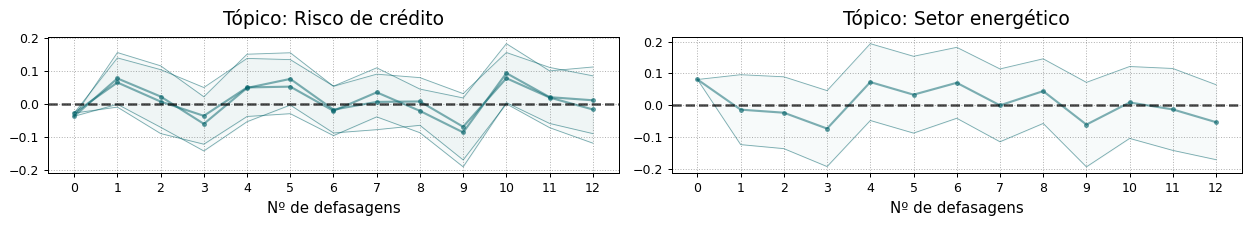

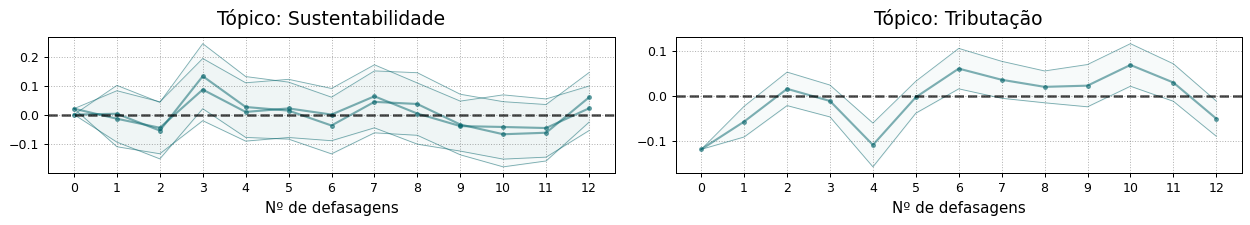

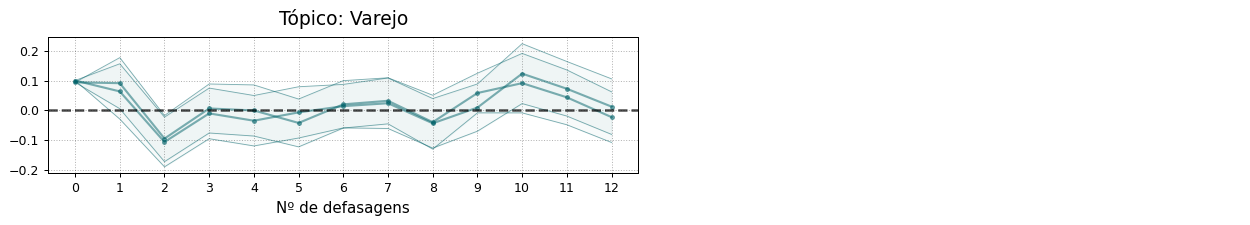

In [52]:
plot_irf_subplots(tópicos, dfs, 2, 'valor', .5, .5, .03, (7,2.6), 90)

# FEVDs sobrepostas

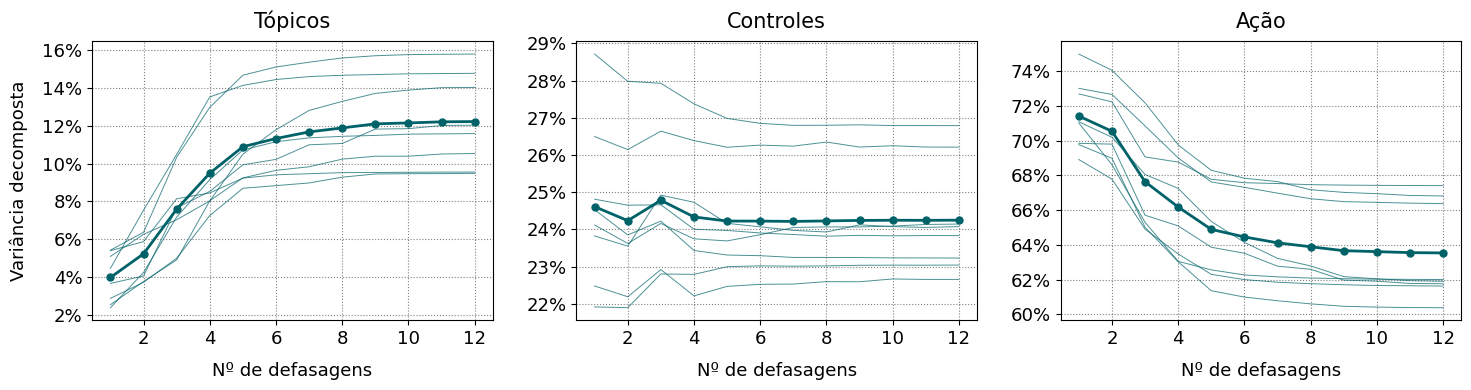

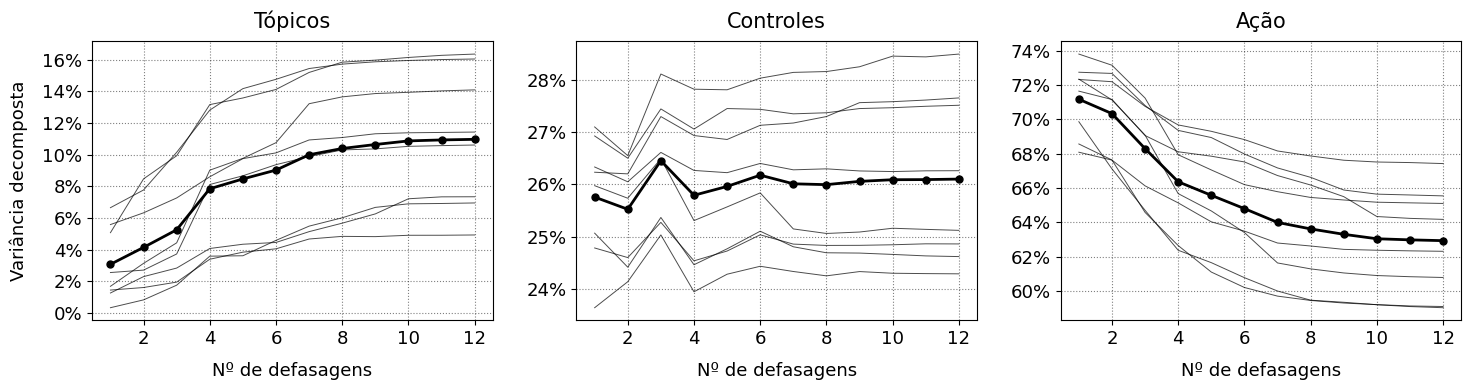

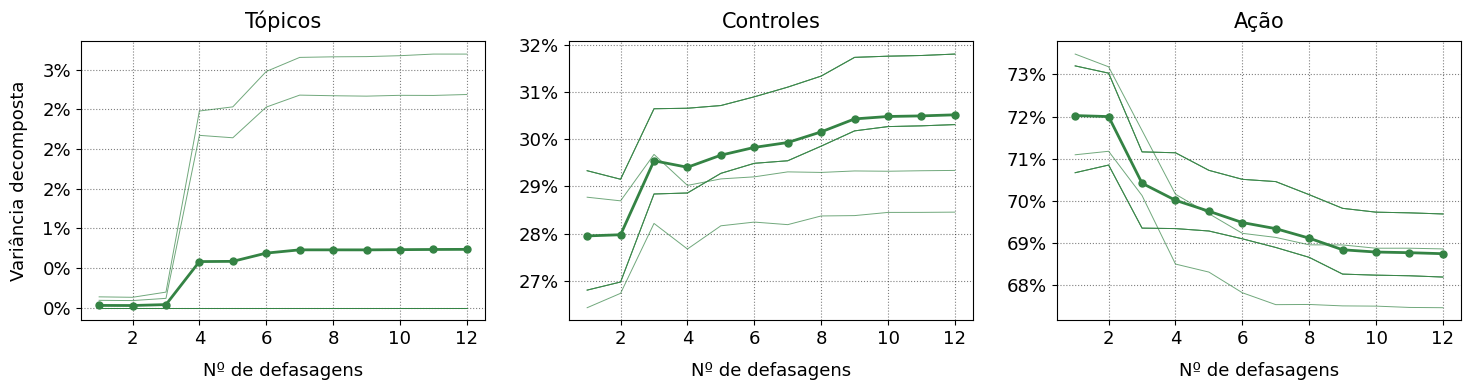

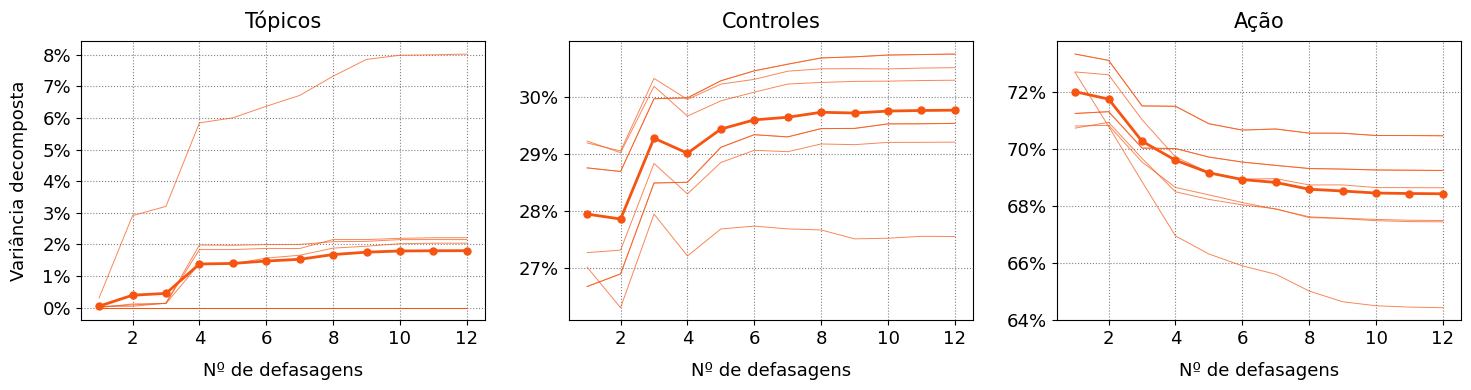

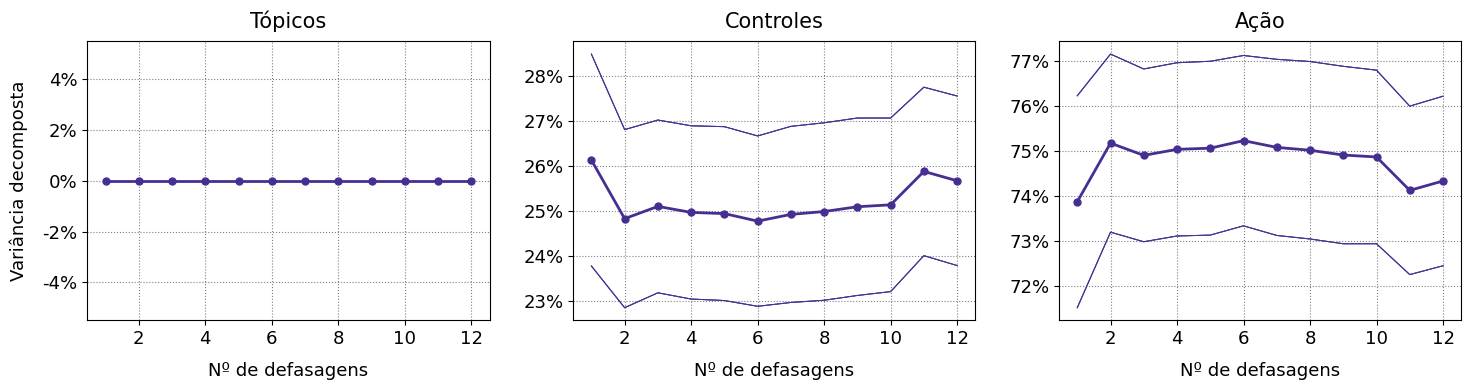

In [54]:
comparações_finais = []
for portal in 'valor epocanegocios globorural revistapegn valorinveste'.split():
    arquivos = [arquivo for arquivo in os.listdir('resultados do VAR') if portal == arquivo.split(' - ')[0]]
    FEVDs = [pd.read_excel(f'resultados do VAR/{arquivo}', sheet_name = 'FEVD', index_col = 0) 
             for arquivo in arquivos]
    
    for arquivo, FEVD in zip(arquivos, FEVDs):
        FEVD.columns = FEVD.columns.map(formatar_nomes_de_tópicos)
        FEVD['Tópicos'] = FEVD[FEVD.columns[FEVD.columns.str.startswith('Tópico')]].sum(axis = 1)
        FEVD['Controles'] = FEVD[FEVD.columns[~FEVD.columns.str.startswith('Tópico')][:-1]].sum(axis = 1)
        FEVD = FEVD[['Tópicos', 'Controles', FEVD.columns[-3]]]
        comparações_finais.append(arquivo.replace(' - total', '').replace('.xlsx', '').split(' - ') + [FEVD.Tópicos.max()])

    tópicos = pd.concat([FEVD['Tópicos'] for FEVD in FEVDs], axis = 1)
    controles = pd.concat([FEVD['Controles'] for FEVD in FEVDs], axis = 1)
    preço_da_ação = pd.concat([FEVD.iloc[:,-3] for FEVD in FEVDs], axis = 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=100)
    for ax, subconjunto, titulo in zip(
            axes,
            [tópicos, controles, preço_da_ação],
            ['Tópicos', 'Controles', 'Ação']):
        
        # média (traço mais forte)
        ax.plot(subconjunto.mean(axis=1),
                linewidth=2, color=cores[portal], marker='o', ms=5)#, label = 'Média das FEVDs')
        
        # todas as séries individuais (traços finos)
        ax.plot(subconjunto, linewidth=.7, alpha=.7, color = cores[portal])#, label = 'FEVD acumulada')
        
        # formatação do eixo y em %
        yticks = ax.get_yticks()[1:-1]
        ax.set_yticks(yticks)
        ax.set_yticklabels([f'{y:.0%}' for y in yticks], fontsize=12)
        
        ax.set_title(titulo, fontsize=15, pad = 10)
        ax.tick_params(axis='x', labelsize=13)
        ax.tick_params(axis='y', labelsize=13)
        ax.set_xlabel('Nº de defasagens', fontsize=13, labelpad=10)
        ax.grid(linestyle=':', color='black', alpha=.5)
        #ax.legend()
    
    # rótulo de y apenas no subplot da esquerda
    axes[0].set_ylabel('Variância decomposta', fontsize=13, labelpad=10)
    
    plt.tight_layout()

    plt.savefig(f'imagem das FEVDs agregadas/{portal}.jpeg', format='jpeg')
    plt.show()

# FEVD máxima 

In [8]:
df = pd.DataFrame(comparações_finais, columns = ['Portal', 'Método', 'D. Dirichlet', 'Ação', 'FEVD'])
df.Portal = df.Portal.apply(lambda x: nomes[x])
df.Método = df.Método.str.title()
df['D. Dirichlet'] = df['D. Dirichlet'].apply(lambda x: 'Ajustadas' if x == 'ajustado' else 'Padrão')
df = df.sort_values('FEVD', ascending = False)
df = df[df.Portal.isin(('Valor Econômico', 'Época Negócios'))].copy()
df = df.pivot_table(index = ['Ação', 'Método', 'D. Dirichlet'], columns = 'Portal', values = 'FEVD')
df.to_excel('Análise das FEVDs.xlsx')
df.map(lambda x: f'{x:.2%}')

Portal                    Valor Econômico Época Negócios
Ação  Método D. Dirichlet                               
PETR3 Batch  Ajustadas             12.03%          4.93%
             Padrão                 9.48%          6.95%
      Online Ajustadas             14.02%         11.43%
             Padrão                11.58%          7.34%
PETR4 Batch  Ajustadas             15.79%         10.61%
             Padrão                10.53%         14.09%
      Online Ajustadas              9.55%         16.04%
             Padrão                14.77%         16.35%